<a href="https://colab.research.google.com/github/michelanthony/CloneSiconosMaster/blob/master/Scikit_FEM_STOKES_NHBC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run the following cell to install dependencies:

In [ ]:
!pip install scikit-fem[all]

In [ ]:
r"""Stokes equations.

This solves for the creeping flow problem in the primitive variables,
i.e. velocity and pressure instead of the stream-function.

Equations

1/ - \nu \Delta {u} + \rho^{-1} \nabla p = {f}
2/ \nabla \cdot {u} = 0

This is an example of a mixed problem because it contains two
different kinds of unknowns; pairs of elements for them have to be
chosen carefully.

One of the simplest workable choices is the
1/ Taylor-Hood element P_2 for velocity
2/ P_1 for pressure.

Once the velocity has been found, the stream-function : \psi can
be calculated by solving the Poisson problem

-\Delta \psi = \rot {u}

where :
{rot} {u} \equiv \partial u_y / \partial x - \partial u_x / \partial y

The boundary conditions are that the stream-function is constant around the impermeable perimeter.
This constant can be taken as zero without loss of generality.

In the weak formulation :
\left(\nabla\phi, \nabla\psi\right) = ( \phi, \rot {u} ) , \forall \phi \in H^1_0(\Omega),

The right-hand side can be converted using Green's theorem and the no-slip condition to not involve the derivatives of the velocity:

(\phi, \rot {u} ) = ( \rot \phi, {u} )
where \rot is the adjoint of \rot :
\rot \phi \equiv \frac { \partial \phi }{ \partial y } \hat{i} - \frac{ \partial\phi }{ \partial x } \hat{j}.

"""

"Stokes equations.\n\nThis solves for the creeping flow problem in the primitive variables,\ni.e. velocity and pressure instead of the stream-function.\n\nEquations\n\n1/ - \\nu \\Delta {u} + \\rho^{-1} \\nabla p = {f}\n2/ \\nabla \\cdot {u} = 0\n\nThis is an example of a mixed problem because it contains two\ndifferent kinds of unknowns; pairs of elements for them have to be\nchosen carefully.\n\nOne of the simplest workable choices is the\n1/ Taylor-Hood element P_2 for velocity\n2/ P_1 for pressure.\n\nOnce the velocity has been found, the stream-function : \\psi can\nbe calculated by solving the Poisson problem\n\n-\\Delta \\psi = \\rot {u}\n\nwhere :\n{rot} {u} \\equiv \\partial u_y / \\partial x - \\partial u_x / \\partial y\n\nThe boundary conditions are that the stream-function is constant around the impermeable perimeter.\nThis constant can be taken as zero without loss of generality.\n\nIn the weak formulation :\n\\left(\\nabla\\phi, \\nabla\\psi\\right) = ( \\phi, \\rot {u} 

In [ ]:
from skfem import *
from skfem.io.json import from_file
from skfem.models.poisson import vector_laplace, mass, laplace
from skfem.models.general import divergence, rot

from matplotlib.tri import Triangulation
from skfem.visuals.matplotlib import plot, draw, savefig

from pathlib import Path
from os.path import splitext
from sys import argv

import numpy as np

In [ ]:
#==== Generate XY Tensor Grid

nx = 5
ny = 5
xgrid = np.linspace(0,1,nx)
ygrid = np.linspace(0,1,ny)

mesh = MeshTri.init_tensor(xgrid, ygrid)

mesh.save(f'my_mesh_grid_{nx}_{ny}.vtk')


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

In [ ]:
#===== Load Mesh

#meshA = MeshTri.load('my_mesh_grid_2_2.vtk')
meshA = MeshTri.load('my_mesh_grid_5_5.vtk')
#meshA = MeshTri.load('MeshTriActive2D_mid.vtk')

#meshA = MeshTri().refined(1)

mesh = meshA.with_boundaries({
            'xmin': lambda xi: xi[0] == 0,
            'xmax': lambda xi: xi[0] == 1
        })

print(mesh)


<skfem MeshTri1 object>
  Number of elements: 32
  Number of vertices: 25
  Number of nodes: 25
  Named boundaries [# facets]: left [4], bottom [4], right [4], top [4], xmin [4], xmax [4]


In [ ]:
#============ FEM Solver for u and p

# Elements and Basis

element = {'u': ElementVector(ElementTriP2()),
           'p': ElementTriP1()}

basis = {variable: Basis(mesh, e, intorder=3)
         for variable, e in element.items()}

print('basis=',basis)

# Linear Form

@LinearForm
def body_force(v, w):
    return w.x[0] * v[1]

# Assembly problem for (u,p)

A = asm(vector_laplace, basis['u'])
B = asm(divergence, basis['u'], basis['p'])
C = asm(mass, basis['p'])

# Matrix
# K = [ A[u,v] = -Delta(u)*v ,  -Bt[u,q]    = div(u)*q
#       B[p,v] = grad(p)*v   ,   1.e-6[p,q] = 1.e-6*p*q ]

# Trial = [u,p]
# Test  = [v,q]

K = bmat([[A, -B.T],
          [-B, 1e-6 * C]], 'csr')

# Right Hand Side
# f  = [ w.u [u]
#          0 [p] ]

f = np.concatenate([asm(body_force, basis['u']),
                    basis['p'].zeros()])

# Solve problem for (u,p)

u_dofs = basis['u'].get_dofs()
print('u_bc_dofs[u^1] =',u_dofs.nodal['u^1'])
print('u_bc_dofs[u^2] =',u_dofs.nodal['u^2'])

xmin_u_dofs = basis['u'].get_dofs('xmin')
xmax_u_dofs = basis['u'].get_dofs('xmax')

xmin_p_dofs = basis['p'].get_dofs('xmin')
xmax_p_dofs = basis['p'].get_dofs('xmax')

print(xmin_u_dofs)
print(xmax_u_dofs)

print(xmin_p_dofs)
print(xmax_p_dofs)

# Set boundary conditions on xmin and xmax

uvp = solve(*condense(K, f, D=u_dofs))

# Extract solution components (u) and (p)

velocity, pressure = np.split(uvp, K.blocks)

basis= {'u': <skfem CellBasis(MeshTri1, ElementVector) object>
  Number of elements: 32
  Number of DOFs: 162
  Size: 73728 B, 'p': <skfem CellBasis(MeshTri1, ElementTriP1) object>
  Number of elements: 32
  Number of DOFs: 25
  Size: 9216 B}
u_bc_dofs[u^1] = [ 0  2  4  6  8 10 18 20 28 30 38 40 42 44 46 48]
u_bc_dofs[u^2] = [ 1  3  5  7  9 11 19 21 29 31 39 41 43 45 47 49]
<skfem DofsView(MeshTri1, ElementVector) object>
  Number of nodal DOFs: 10 ['u^1' 'u^2']
  Number of facet DOFs: 8 ['u^1' 'u^2']
<skfem DofsView(MeshTri1, ElementVector) object>
  Number of nodal DOFs: 10 ['u^1' 'u^2']
  Number of facet DOFs: 8 ['u^1' 'u^2']
<skfem DofsView(MeshTri1, ElementTriP1) object>
  Number of nodal DOFs: 5 ['u']
<skfem DofsView(MeshTri1, ElementTriP1) object>
  Number of nodal DOFs: 5 ['u']


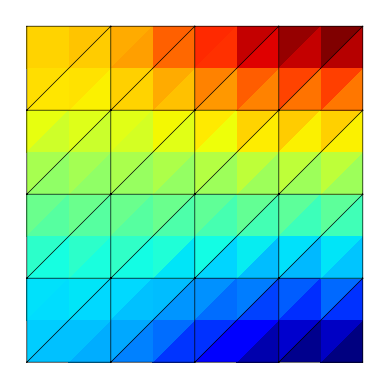

In [ ]:
# Plot results pressure

ax = draw(mesh)
plot(basis['p'], pressure, ax=ax)
savefig('result_pressure.png')


<skfem CellBasis(MeshTri1, ElementVector) object>
  Number of elements: 32
  Number of DOFs: 162
  Size: 73728 B
nodal_dofs= (2, 25)
edge_dofs= (0, 0)
facet_dofs= (2, 56)
velocity_nodes.shape= (2, 25)
<skfem CellBasis(MeshTri1, ElementTriP1) object>
  Number of elements: 32
  Number of DOFs: 25
  Size: 9216 B
pressure.shape= 25


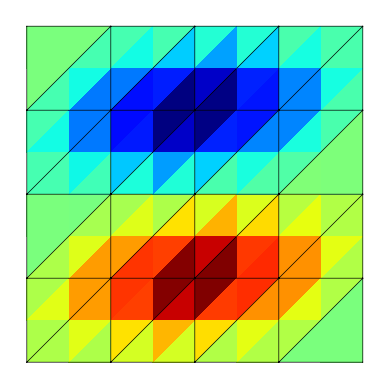

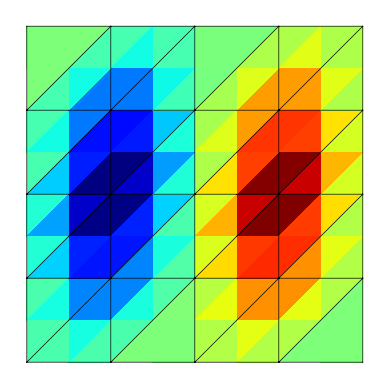

In [ ]:
import matplotlib.pyplot as plt
import skfem

# Plot results pressure
print(basis['u'])

print('nodal_dofs=',basis['u'].nodal_dofs.shape)
print('edge_dofs=',basis['u'].edge_dofs.shape)
print('facet_dofs=',basis['u'].facet_dofs.shape)

velocity_nodes = velocity[basis['u'].nodal_dofs]
print('velocity_nodes.shape=',velocity_nodes.shape)

print(basis['p'])
print('pressure.shape=',pressure.shape[0])

ax = draw(mesh)
plot(basis['p'], velocity_nodes[0], ax=ax)
savefig('result_velocity_x.png')

ax = draw(mesh)
plot(basis['p'], velocity_nodes[1], ax=ax)
savefig('result_velocity_y.png')


ValueError: Argument U has a size 9 which does not match 25, the number of arrow positions

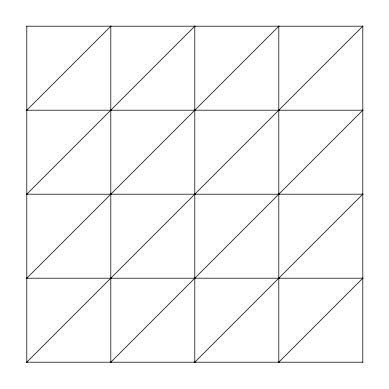

In [ ]:
# Plot result velocity

ax = draw(mesh)
velocity1 = velocity[basis['u'].nodal_dofs]

ax.quiver(*mesh.p, *velocity1, mesh.p[0])  # colour by buoyancy
savefig('result_velocity.png')

In [ ]:
# Export results as VTK

mesh.save('result_pressure.vtk', {'pressure': pressure[basis['p'].nodal_dofs].T})
mesh.save('result_velocity.vtk', {'velocity': velocity[basis['u'].nodal_dofs].T})

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to velocity.

In [ ]:
#============ FEM Solver for (psi)

# Basis for (psi)

basis['psi'] = basis['u'].with_element(ElementTriP2())

# Assembly problem for (psi)

A = asm(laplace, basis['psi'])

vorticity = asm(rot, basis['psi'], w=basis['u'].interpolate(velocity))

# Solve problem for (psi)

psi = solve(*condense(A, vorticity, D=basis['psi'].get_dofs()))

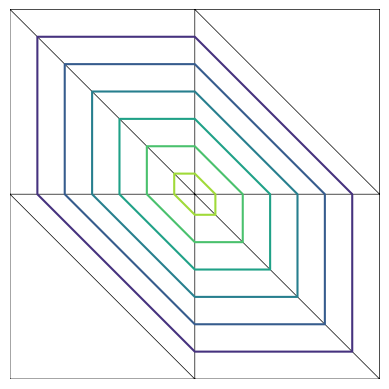

In [ ]:
# Plot results psi

mesh_tri = Triangulation(*mesh.p, mesh.t.T)

ax = draw(mesh)
ax.tricontour(mesh_tri, psi[basis['psi'].nodal_dofs.flatten()])
savefig('result_psi.png')


In [ ]:
# Save results as VTK

mesh.save('result_psi.vtk', {'psi': psi[basis['psi'].nodal_dofs].T})


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.